In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import h5py
from IPython.display import display
import numpy as np
from os.path import join as pj
from os import getcwd as cwd
import pandas as pd
import random
import sys
import torch
from tqdm import tqdm
import visdom

# Data Augument
from dataset.classification.loader import create_validation_split, load_validation_data, create_train_data, create_train_data_DCL
# Evaluation
from evaluation.classification.evaluate import accuracy, confusion_matrix
# Model
from model.resnet.resnet import ResNet

import matplotlib.pyplot as plt
%matplotlib inline

### Test Config

In [3]:
class args:
    # experiment_name
    experiment_name = "resnet50_b20_r45_lr1e-5_resize_crossvalid"
    # data split
    train_ratio = 0.8 # unused parameters
    test_ratio = 0.2
    # paths
    all_data_path = pj(cwd(), "data/all_classification_data/classify_insect_resize_std")
    model_root = pj(cwd(), "output_model/classification/ResNet101", experiment_name)
    figure_root = pj(cwd(), "figure/classification/ResNet101", experiment_name)
    # train config
    model_name = "resnet50" # choice ["resnet18", "resnet34", "resnet50", "resnet101", "resnet152"]
    bs = 20
    lr = 1e-5
    lamda = 1e-2
    nepoch = 40
    rotate = 45
    pretrain = True
    param_freeze = False
    correction_term = False
    sampling = None # choice [None, "RandomSample", "RandomOverSample"]
    augment = None # choice [None, "RandomSizeCrop", "RegionConfusionMechanism"]
    optimizer = "AdamW" # choice ["Adam, AdamW"]
    activation_function = "ReLU" # choice ["ReLU", "LeakyReLU", "RReLU"]
    # test config
    save_fig = True
    save_df = True
    # visdom
    visdom = True
    port = 8097

In [4]:
dataset_name = args.all_data_path.split('/')[-1]
if dataset_name == 'classify_insect_std':
    args.labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
                    'Lepidoptera', 'Plecoptera', 'Trichoptera']
elif dataset_name == 'classify_insect_resize_std':
    args.labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
                    'Lepidoptera', 'Plecoptera', 'Trichoptera']
elif dataset_name == 'classify_insect_std_resize':
    args.labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
                    'Lepidoptera', 'Plecoptera', 'Trichoptera']

### Load Model

In [11]:
model = ResNet(args.model_name, len(args.labels), pretrain=args.pretrain, training=True, param_freeze=args.param_freeze, vis_feature=True, activation_function=args.activation_function).cuda()
model.load_state_dict(torch.load(pj(args.model_root, "final.pth")))

### Make test data

In [12]:
with h5py.File(args.all_data_path) as f:
    X = f["X"][:]
    Y = f["Y"][:]
_, ntests = np.unique(Y, return_counts=True)
train_idxs, test_idxs = create_validation_split(Y, args.test_ratio)

In [13]:
if args.sampling == "RandomSample":
    print("sampling = RandomSample")
    new_train_idx = get_randomsampled_idx(Y, train_idxs[4])
    xtr, ytr, xte, yte = load_validation_data(X, Y, new_train_idx, test_idxs[4])
elif args.sampling == "RandomOverSample":
    print("sampling == RandomOverSample")
    new_train_idx = get_randomoversampled_idx(Y, train_idxs[4])
    xtr, ytr, xte, yte = load_validation_data(X, Y, new_train_idx, test_idxs[4])
else:
    print("sampling = None")
    xtr, ytr, xte, yte = load_validation_data(X, Y, train_idxs[4], test_idxs[4])

sampling = None


# Visualize Model Feature

In [14]:
index = 0

In [15]:
index += 1

In [16]:
x = xte[index][None, :, :, :].cuda()
model_features = model(x)
model_features.keys()

dict_keys(['conv_block_1', 'conv_block_2', 'conv_block_3', 'conv_block_4'])

### Input Image

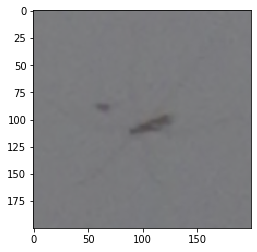

In [17]:
plt.imshow(xte[index].cpu().numpy().transpose(1,2,0).astype("uint8"))

### Conv Block 1

In [18]:
block1_index = 0

ブロック1の特徴量


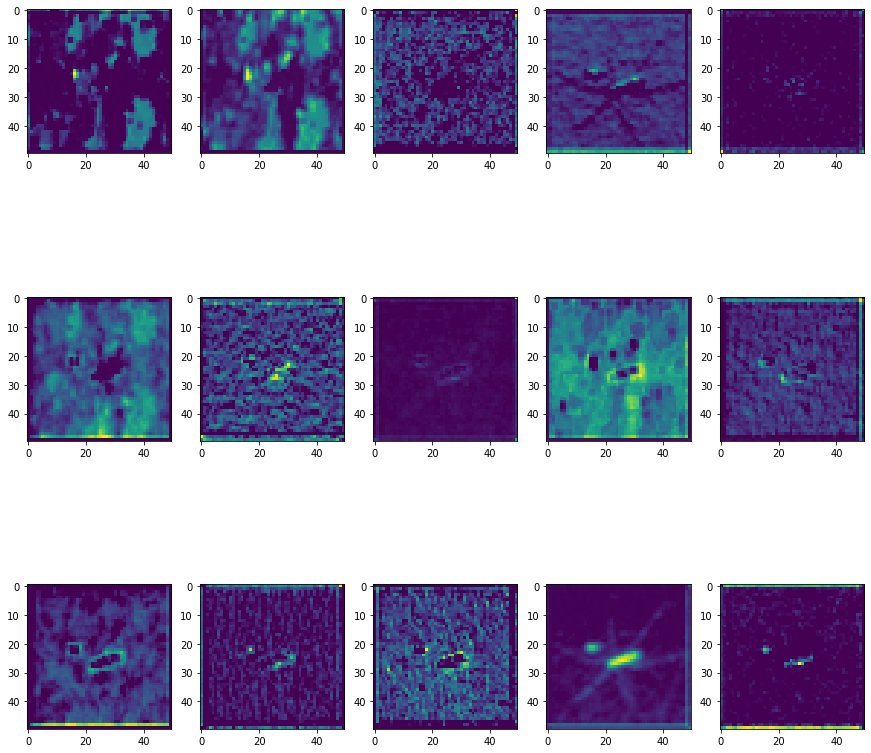

In [19]:
print("ブロック1の特徴量")
fig, axes = plt.subplots(3, 5, figsize=(15,15))
axes[0,0].imshow(model_features['conv_block_1'][0, block1_index].detach().cpu().numpy())
axes[0,1].imshow(model_features['conv_block_1'][0, block1_index + 1].detach().cpu().numpy())
axes[0,2].imshow(model_features['conv_block_1'][0, block1_index + 2].detach().cpu().numpy())
axes[0,3].imshow(model_features['conv_block_1'][0, block1_index + 3].detach().cpu().numpy())
axes[0,4].imshow(model_features['conv_block_1'][0, block1_index + 4].detach().cpu().numpy())
axes[1,0].imshow(model_features['conv_block_1'][0, block1_index + 5].detach().cpu().numpy())
axes[1,1].imshow(model_features['conv_block_1'][0, block1_index + 6].detach().cpu().numpy())
axes[1,2].imshow(model_features['conv_block_1'][0, block1_index + 7].detach().cpu().numpy())
axes[1,3].imshow(model_features['conv_block_1'][0, block1_index + 8].detach().cpu().numpy())
axes[1,4].imshow(model_features['conv_block_1'][0, block1_index + 9].detach().cpu().numpy())
axes[2,0].imshow(model_features['conv_block_1'][0, block1_index + 10].detach().cpu().numpy())
axes[2,1].imshow(model_features['conv_block_1'][0, block1_index + 11].detach().cpu().numpy())
axes[2,2].imshow(model_features['conv_block_1'][0, block1_index + 12].detach().cpu().numpy())
axes[2,3].imshow(model_features['conv_block_1'][0, block1_index + 13].detach().cpu().numpy())
axes[2,4].imshow(model_features['conv_block_1'][0, block1_index + 14].detach().cpu().numpy())
block1_index += 15

### Conv Block 2

In [20]:
block2_index = 0

ブロック2の特徴量


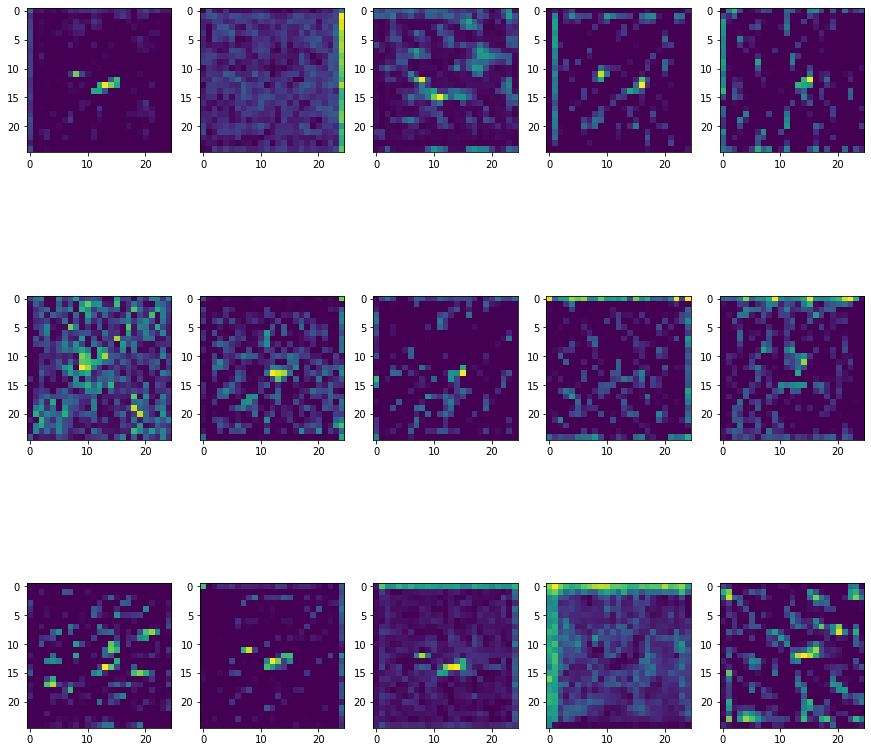

In [21]:
print("ブロック2の特徴量")
fig, axes = plt.subplots(3, 5, figsize=(15,15))
axes[0,0].imshow(model_features['conv_block_2'][0, block2_index].detach().cpu().numpy())
axes[0,1].imshow(model_features['conv_block_2'][0, block2_index + 1].detach().cpu().numpy())
axes[0,2].imshow(model_features['conv_block_2'][0, block2_index + 2].detach().cpu().numpy())
axes[0,3].imshow(model_features['conv_block_2'][0, block2_index + 3].detach().cpu().numpy())
axes[0,4].imshow(model_features['conv_block_2'][0, block2_index + 4].detach().cpu().numpy())
axes[1,0].imshow(model_features['conv_block_2'][0, block2_index + 5].detach().cpu().numpy())
axes[1,1].imshow(model_features['conv_block_2'][0, block2_index + 6].detach().cpu().numpy())
axes[1,2].imshow(model_features['conv_block_2'][0, block2_index + 7].detach().cpu().numpy())
axes[1,3].imshow(model_features['conv_block_2'][0, block2_index + 8].detach().cpu().numpy())
axes[1,4].imshow(model_features['conv_block_2'][0, block2_index + 9].detach().cpu().numpy())
axes[2,0].imshow(model_features['conv_block_2'][0, block2_index + 10].detach().cpu().numpy())
axes[2,1].imshow(model_features['conv_block_2'][0, block2_index + 11].detach().cpu().numpy())
axes[2,2].imshow(model_features['conv_block_2'][0, block2_index + 12].detach().cpu().numpy())
axes[2,3].imshow(model_features['conv_block_2'][0, block2_index + 13].detach().cpu().numpy())
axes[2,4].imshow(model_features['conv_block_2'][0, block2_index + 14].detach().cpu().numpy())
block2_index += 1

### Conv Block 3

In [22]:
block3_index = 0

ブロック3の特徴量


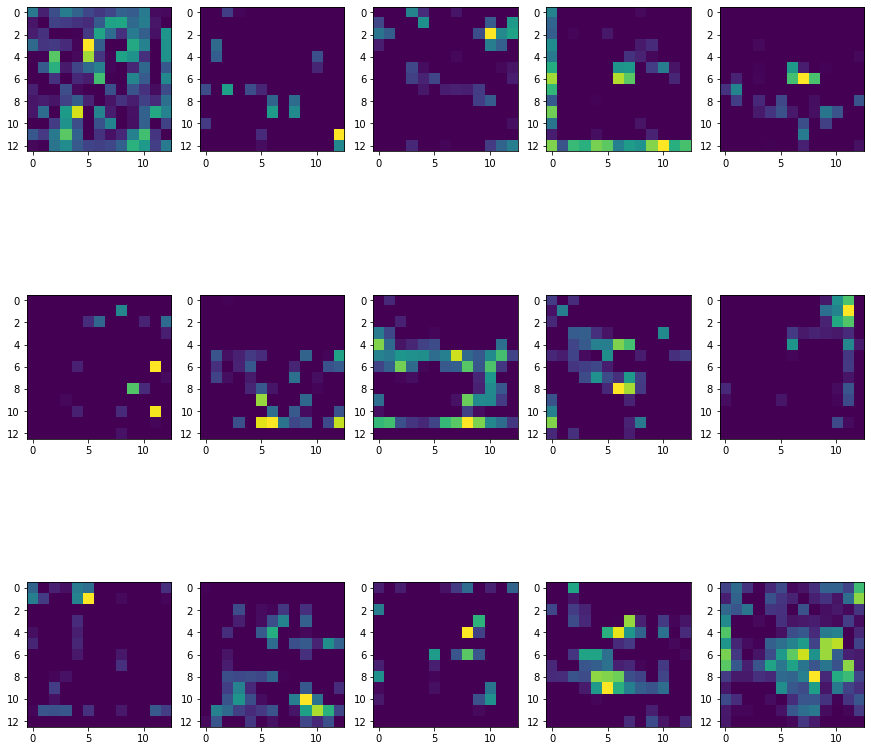

In [23]:
print("ブロック3の特徴量")
fig, axes = plt.subplots(3, 5, figsize=(15,15))
axes[0,0].imshow(model_features['conv_block_3'][0, block3_index].detach().cpu().numpy())
axes[0,1].imshow(model_features['conv_block_3'][0, block3_index + 1].detach().cpu().numpy())
axes[0,2].imshow(model_features['conv_block_3'][0, block3_index + 2].detach().cpu().numpy())
axes[0,3].imshow(model_features['conv_block_3'][0, block3_index + 3].detach().cpu().numpy())
axes[0,4].imshow(model_features['conv_block_3'][0, block3_index + 4].detach().cpu().numpy())
axes[1,0].imshow(model_features['conv_block_3'][0, block3_index + 5].detach().cpu().numpy())
axes[1,1].imshow(model_features['conv_block_3'][0, block3_index + 6].detach().cpu().numpy())
axes[1,2].imshow(model_features['conv_block_3'][0, block3_index + 7].detach().cpu().numpy())
axes[1,3].imshow(model_features['conv_block_3'][0, block3_index + 8].detach().cpu().numpy())
axes[1,4].imshow(model_features['conv_block_3'][0, block3_index + 9].detach().cpu().numpy())
axes[2,0].imshow(model_features['conv_block_3'][0, block3_index + 10].detach().cpu().numpy())
axes[2,1].imshow(model_features['conv_block_3'][0, block3_index + 11].detach().cpu().numpy())
axes[2,2].imshow(model_features['conv_block_3'][0, block3_index + 12].detach().cpu().numpy())
axes[2,3].imshow(model_features['conv_block_3'][0, block3_index + 13].detach().cpu().numpy())
axes[2,4].imshow(model_features['conv_block_3'][0, block3_index + 14].detach().cpu().numpy())
block3_index += 1

### Conv Block 4

In [24]:
block4_index = 0

ブロック4の特徴量


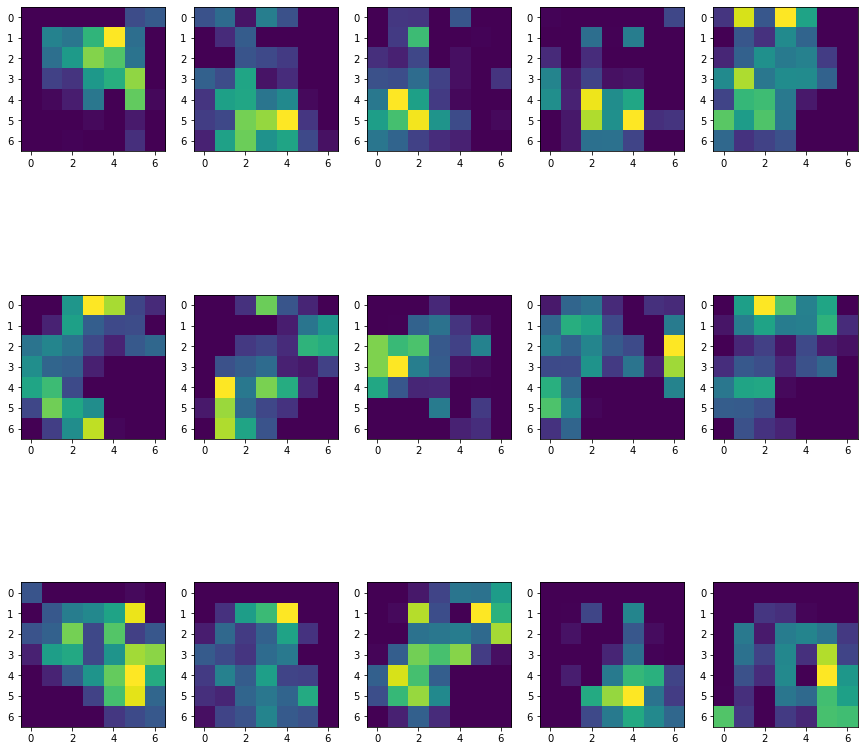

In [25]:
print("ブロック4の特徴量")
fig, axes = plt.subplots(3, 5, figsize=(15,15))
axes[0,0].imshow(model_features['conv_block_4'][0, block4_index].detach().cpu().numpy())
axes[0,1].imshow(model_features['conv_block_4'][0, block4_index + 1].detach().cpu().numpy())
axes[0,2].imshow(model_features['conv_block_4'][0, block4_index + 2].detach().cpu().numpy())
axes[0,3].imshow(model_features['conv_block_4'][0, block4_index + 3].detach().cpu().numpy())
axes[0,4].imshow(model_features['conv_block_4'][0, block4_index + 4].detach().cpu().numpy())
axes[1,0].imshow(model_features['conv_block_4'][0, block4_index + 5].detach().cpu().numpy())
axes[1,1].imshow(model_features['conv_block_4'][0, block4_index + 6].detach().cpu().numpy())
axes[1,2].imshow(model_features['conv_block_4'][0, block4_index + 7].detach().cpu().numpy())
axes[1,3].imshow(model_features['conv_block_4'][0, block4_index + 8].detach().cpu().numpy())
axes[1,4].imshow(model_features['conv_block_4'][0, block4_index + 9].detach().cpu().numpy())
axes[2,0].imshow(model_features['conv_block_4'][0, block4_index + 10].detach().cpu().numpy())
axes[2,1].imshow(model_features['conv_block_4'][0, block4_index + 11].detach().cpu().numpy())
axes[2,2].imshow(model_features['conv_block_4'][0, block4_index + 12].detach().cpu().numpy())
axes[2,3].imshow(model_features['conv_block_4'][0, block4_index + 13].detach().cpu().numpy())
axes[2,4].imshow(model_features['conv_block_4'][0, block4_index + 14].detach().cpu().numpy())
block4_index += 1